In [1]:
%matplotlib inline
import os.path
import re

import matplotlib.pyplot as plt
import numpy as np


In [5]:
def parse_file(f):
    with open(f) as fd:
        lines = fd.readlines()
        vals = [float(ln.split(',')[1]) for ln in lines if len(ln) > 0]
        if len(vals) > 0:
            return (np.mean(vals), np.median(vals), np.max(vals), np.min(vals))
        else: return (np.nan, np.nan, np.nan, np.nan)
        
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if np.isnan(height):
            height = 0.0
            label = "N/A"
        else:
            label = "{:.2f}".format(height)
        ax.text(rect.get_x() + rect.get_width()/2, 1.001*height,
                label,
                ha='center', va='bottom')
        

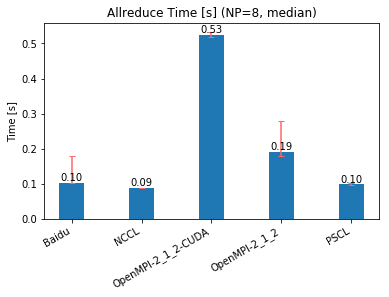

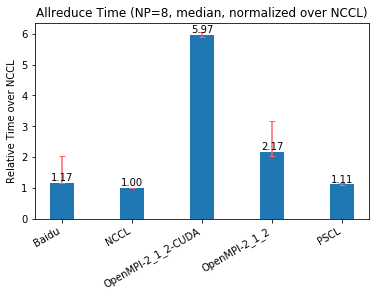

In [7]:
# result directory
files = !find build/20180608-01/ -type f
files = sorted(files)

# size
target_size = "268435456"

# NP
target_np = "8"

# "median" or "mean"
mode="median"

# filter files
files = [f for f in files if 'size{}'.format(target_size) in f and 'nproc{}'.format(target_np) in f]

assert(len(files) > 0)

target_names = [re.search(r'/(.*)-size', f).group(1) 
                for f in sorted(files)]
target_names = [os.path.basename(t) for t in target_names]

# print("targets = {}".format(target_names))
vals = [parse_file(f) for f in files]

if mode == "median":
    vals2 = [v[1] for v in vals] # median
    vals_err = np.array([[v[1] - v[3],v[2] - v[1]] for v in vals]).transpose()
elif mode == "mean":
    vals2 = [v[0] for v in vals] # median
    vals_err = np.array([[v[0] - v[3],v[2] - v[0]] for v in vals]).transpose()
else:
    assert False
# print("vals={}".format(vals))

width = 0.35

fig, ax = plt.subplots()
ind = np.arange(len(vals2)) + 1
rects1 = ax.bar(ind, vals2, width, yerr=vals_err, capsize=3, ecolor='#FF6666')

# ax.set_xlabel('Library')
ax.set_ylabel('Time [s]')
ax.set_xticks(ind)
ax.set_xticklabels(target_names)
ax.set_title('Allreduce Time [s] (NP={}, {})'.format(target_np, mode))

# NCCL-normalized
nccl_ind = target_names.index('NCCL')
nccl_time = vals2[nccl_ind]
rel_time = np.array(vals2) / nccl_time
rel_err = vals_err / nccl_time
autolabel(rects1)
fig.autofmt_xdate()

fig, ax = plt.subplots()
ind = np.arange(len(rel_time)) + 1
rects2 = ax.bar(ind, rel_time, width, yerr=rel_err, capsize=3, ecolor='#FF6666')

ax.set_title('Allreduce Time (NP={}, {}, normalized over NCCL)'.format(target_np, mode))
#ax.set_xlabel('Library')
ax.set_ylabel('Relative Time over NCCL')
ax.set_xticks(ind)
ax.set_xticklabels(target_names)

autolabel(rects2)
fig.autofmt_xdate()

plt.show()


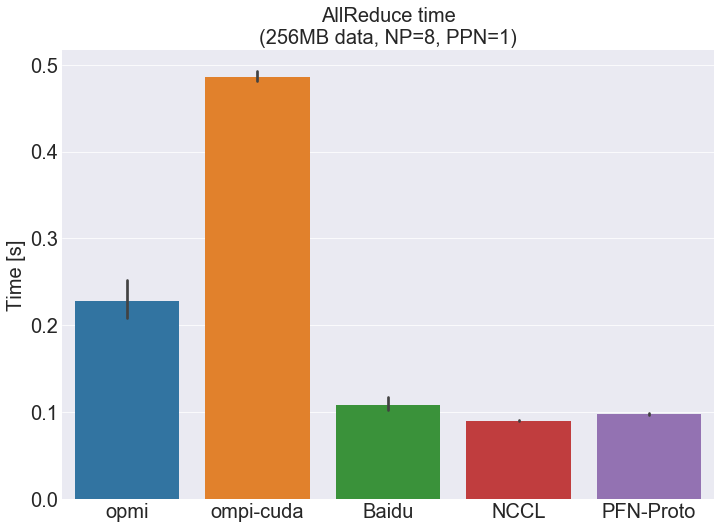

In [99]:
# ResearchBlogのための測定
import seaborn as sns
import pandas as pd

sns.set_style('darkgrid')

files = [
    'build/20180608-02/OpenMPI-2_1_3-size268435456-nproc8.dat',
    'build/20180608-02/OpenMPI-2_1_3-CUDA-size268435456-nproc8.dat',
    'build/20180608-02/Baidu-size268435456-nproc8.dat',
    'build/20180608-02/NCCL-size268435456-nproc8.dat',
    'build/20180608-02/PSCL-size268435456-nproc8.dat',
]

# "median" or "mean"
mode="median"

labels = [re.search(r'/(.*)-size', f).group(1) 
                for f in files]
labels = [os.path.basename(t) for t in target_names]

labels = [
    'opmi',
    'ompi-cuda',
    'Baidu',
    'NCCL',
    'PFN-Proto'
]

# print("targets = {}".format(target_names))
data = None
for i, f in enumerate(files):
    df = pd.read_csv(f, header=None)
    
    if data is None:
        data = df.loc[:,1]
    else:
        data = pd.concat([data, df.loc[:,1]], axis=1)    

data.columns = labels
ax = sns.barplot(data=data, estimator=np.mean)
ax.set_xticklabels(labels=labels)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
ax.set_ylabel(r'Time [s]', fontsize=20)

ax.set_title("AllReduce time\n(256MB data, NP=8, PPN=1)", fontsize=20)

fig = ax.get_figure()
fig.set_size_inches(11.7, 8.27)
fig.savefig("graph.pdf")

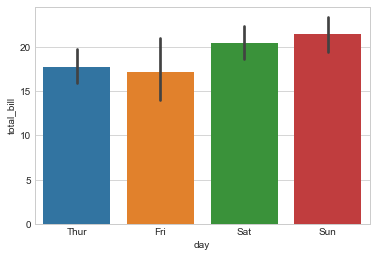

In [14]:
import seaborn as sns
sns.set_style('whitegrid')
tips = sns.load_dataset('tips')

ax = sns.barplot(x="day", y="total_bill", data=tips)